<a href="https://colab.research.google.com/github/bielalpha/Tensorflow_study/blob/master/right_Image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!nvidia-smi

Wed Oct 12 14:53:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W /  70W |    286MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import classification_report

In [9]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)
train_test_dir = os.path.join('/content/drive/MyDrive/', 'Disiase - Copy')
train_dataset = tf.keras.utils.image_dataset_from_directory(train_test_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 7797 files belonging to 3 classes.


In [10]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(train_test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 7797 files belonging to 3 classes.


In [11]:
new_directory = os.path.join('/content/drive/MyDrive/', 'Disiase_refactor')
validation_dataset_true = tf.keras.utils.image_dataset_from_directory(new_directory,
                                                                 shuffle=False,
                                                                 seed=123,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 32 files belonging to 3 classes.


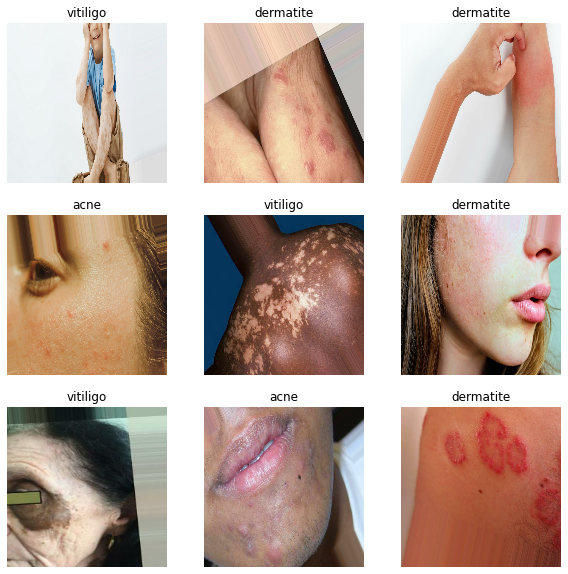

In [12]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [14]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 196
Number of test batches: 48


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [16]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

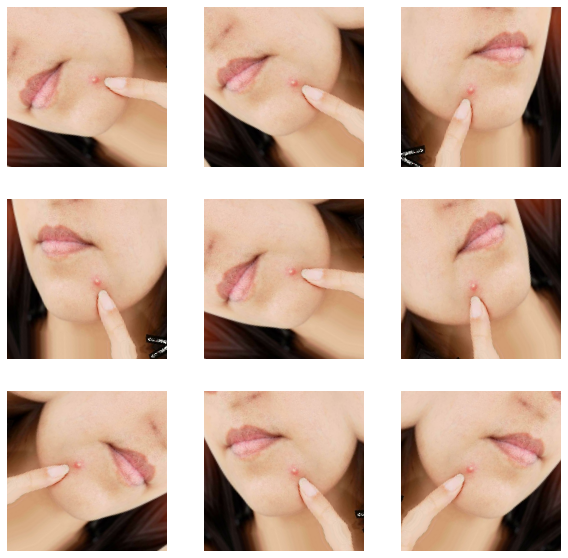

In [17]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [18]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [19]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [20]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [21]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [22]:
base_model.trainable = False

In [23]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [24]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [25]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [26]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [27]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [29]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

196/196 [==============================] - 750s 3s/step - loss: 1.2245 - accuracy: 0.3188


In [30]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.22
initial accuracy: 0.32


In [31]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
244/244 [==============================] - 59s 225ms/step - loss: 0.0588 - accuracy: 0.3310 - val_loss: -0.4429 - val_accuracy: 0.3340
Epoch 2/10
244/244 [==============================] - 56s 225ms/step - loss: -0.6564 - accuracy: 0.3392 - val_loss: -0.9724 - val_accuracy: 0.3368
Epoch 3/10
244/244 [==============================] - 56s 225ms/step - loss: -1.2191 - accuracy: 0.3422 - val_loss: -1.5090 - val_accuracy: 0.3415
Epoch 4/10
244/244 [==============================] - 56s 226ms/step - loss: -1.7713 - accuracy: 0.3432 - val_loss: -2.0398 - val_accuracy: 0.3466
Epoch 5/10
244/244 [==============================] - 56s 225ms/step - loss: -2.3397 - accuracy: 0.3473 - val_loss: -2.5430 - val_accuracy: 0.3506
Epoch 6/10
244/244 [==============================] - 55s 224ms/step - loss: -2.9339 - accuracy: 0.3467 - val_loss: -3.1348 - val_accuracy: 0.3506
Epoch 7/10
244/244 [==============================] - 55s 225ms/step - loss: -3.5073 - accuracy: 0.3465 - val_loss: -3.

In [32]:
base_model.trainable = True

In [33]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [34]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [36]:
len(model.trainable_variables)

56

In [37]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
244/244 [==============================] - 63s 234ms/step - loss: -63.8949 - accuracy: 0.3605 - val_loss: -100.9712 - val_accuracy: 0.3750
Epoch 11/20
244/244 [==============================] - 57s 232ms/step - loss: -114.2245 - accuracy: 0.3814 - val_loss: -122.0677 - val_accuracy: 0.4089
Epoch 12/20
244/244 [==============================] - 58s 233ms/step - loss: -130.9309 - accuracy: 0.4108 - val_loss: -138.8047 - val_accuracy: 0.4189
Epoch 13/20
244/244 [==============================] - 57s 232ms/step - loss: -141.7271 - accuracy: 0.4240 - val_loss: -137.8815 - val_accuracy: 0.4480
Epoch 14/20
244/244 [==============================] - 57s 232ms/step - loss: -151.1624 - accuracy: 0.4340 - val_loss: -148.2148 - val_accuracy: 0.4558
Epoch 15/20
244/244 [==============================] - 58s 233ms/step - loss: -159.3887 - accuracy: 0.4443 - val_loss: -163.9077 - val_accuracy: 0.4729
Epoch 16/20
244/244 [==============================] - 57s 232ms/step - loss: -167.0176 -

In [38]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

48/48 [==============================] - 6s 113ms/step - loss: -197.1357 - accuracy: 0.4837
Test accuracy : 0.4837239682674408


Predictions:
 [1 0 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1]
Labels:
 [1 0 1 1 0 2 1 0 2 2 1 0 1 1 0 0 1 2 1 0 0 1 2 0 2 2 0 2 2 0 2 2]


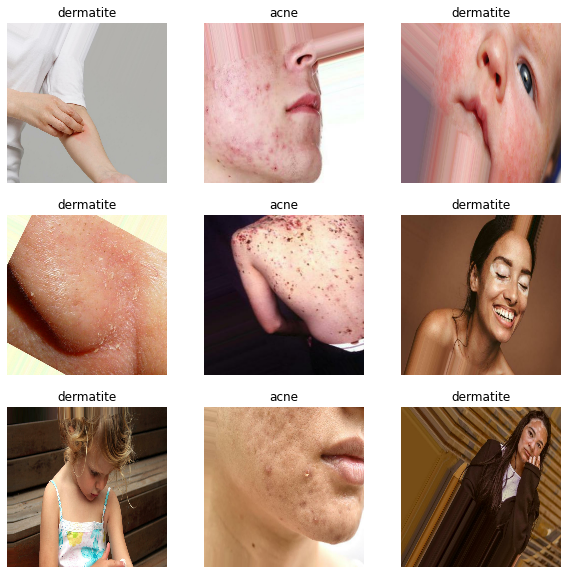

In [39]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [40]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [41]:
from sklearn.metrics import confusion_matrix,classification_report
confusion_matrix(predictions, label_batch)

array([[10,  3,  0],
       [ 1,  7, 11],
       [ 0,  0,  0]])

Novo modelo

In [42]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [43]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(160, 160, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [44]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
epochs=20
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/20
244/244 [==============================] - 55s 218ms/step - loss: 0.9892 - accuracy: 0.4915 - val_loss: 0.8907 - val_accuracy: 0.5732
Epoch 2/20
244/244 [==============================] - 54s 218ms/step - loss: 0.8937 - accuracy: 0.5618 - val_loss: 0.8582 - val_accuracy: 0.5635
Epoch 3/20
244/244 [==============================] - 54s 217ms/step - loss: 0.8085 - accuracy: 0.6225 - val_loss: 0.7147 - val_accuracy: 0.6847
Epoch 4/20
244/244 [==============================] - 54s 218ms/step - loss: 0.6853 - accuracy: 0.6927 - val_loss: 0.6230 - val_accuracy: 0.7409
Epoch 5/20
244/244 [==============================] - 54s 218ms/step - loss: 0.5582 - accuracy: 0.7608 - val_loss: 0.4365 - val_accuracy: 0.8229
Epoch 6/20
244/244 [==============================] - 54s 218ms/step - loss: 0.4310 - accuracy: 0.8212 - val_loss: 0.3900 - val_accuracy: 0.8393
Epoch 7/20
244/244 [==============================] - 54s 218ms/step - loss: 0.3064 - accuracy: 0.8782 - val_loss: 0.2589 - val_ac

In [46]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

48/48 [==============================] - 6s 108ms/step - loss: 0.0359 - accuracy: 0.9889
Test accuracy : 0.9889323115348816


In [47]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [48]:
pred = model.predict(validation_dataset_true)
classes = np.argmax(pred, axis = 1)

# Retrieve a batch of images from the test set
image_batch, label_batch = validation_dataset_true.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Labels True:\n', label_batch)
print('Labels Predict:\n',classes)
confusion_matrix(classes, label_batch)
target_names = ['acne', 'dermatite', 'vitiligo']
print(classification_report(label_batch, classes, target_names=target_names))

Labels True:
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2]
Labels Predict:
 [0 0 0 0 0 0 0 1 2 0 0 1 1 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 1 2 2 0]
              precision    recall  f1-score   support

        acne       0.82      0.82      0.82        11
   dermatite       0.82      0.90      0.86        10
    vitiligo       0.90      0.82      0.86        11

    accuracy                           0.84        32
   macro avg       0.85      0.85      0.84        32
weighted avg       0.85      0.84      0.84        32



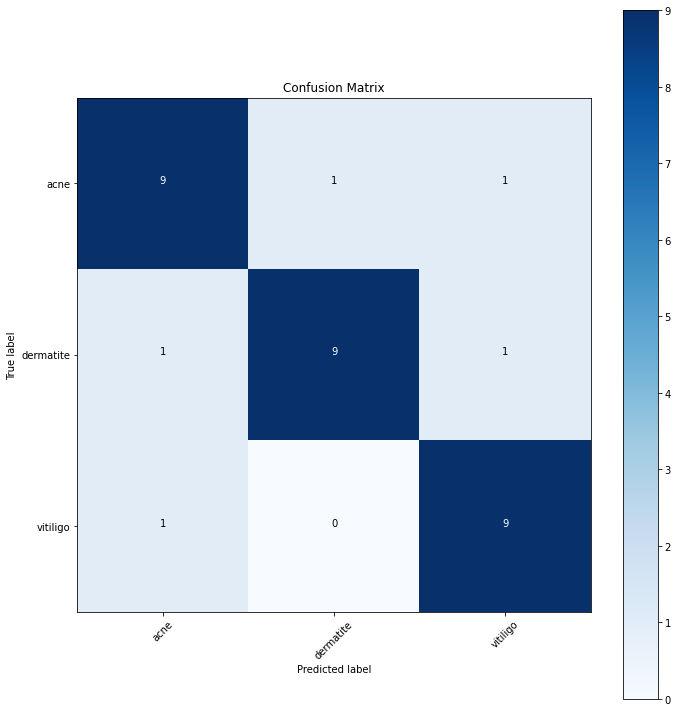

In [52]:
target_names = ['acne', 'dermatite', 'vitiligo']
cm = confusion_matrix(classes, label_batch)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')